## Using PAMI version of Emotic dataset
### and opencv: https://realpython.com/face-recognition-with-python/

In [40]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

root_dir = '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/'
cascPath = '/Users/nealdesai/Documents/CSClasses/CS766-CV/project/HumanEmotionRecognition/haarcascade_frontalface_default.xml'

In [2]:
!pwd

/Users/nealdesai/Documents/CSClasses/CS766-CV/project/HumanEmotionRecognition


In [3]:
annotations = loadmat('Annotations.mat')

In [4]:
annotations.keys()

dict_keys(['__header__', '__version__', '__globals__', 'test', 'train', 'val'])

In [5]:
print(annotations['train'].shape[1])
print(annotations['test'].shape)
print(annotations['val'].shape)

17077
(1, 4389)
(1, 2088)


In [6]:
for i,val in enumerate(annotations['train'][:,12][0]):
    print(i, ': ', val[0])

0 :  COCO_val2014_000000122997.jpg
1 :  mscoco/images
2 :  [(array([[640]], dtype=uint16), array([[425]], dtype=uint16))]
3 :  [(array(['mscoco'], dtype='<U6'), array([[(array([[122997]], dtype=int32), array([[558850]], dtype=int32))]],
      dtype=[('image_id', 'O'), ('annotations_id', 'O')]))]
4 :  [(array([[246,  63, 458, 380]], dtype=uint16), array([[(array([[array(['Engagement'], dtype='<U10')]], dtype=object),)]],
      dtype=[('categories', 'O')]), array([[(array([[5]], dtype=uint8), array([[3]], dtype=uint8), array([[8]], dtype=uint8))]],
      dtype=[('valence', 'O'), ('arousal', 'O'), ('dominance', 'O')]), array(['Female'], dtype='<U6'), array(['Adult'], dtype='<U5'))
 (array([[141,  47, 348, 343]], dtype=uint16), array([[(array([[array(['Disconnection'], dtype='<U13'),
        array(['Engagement'], dtype='<U10'),
        array(['Peace'], dtype='<U5')]], dtype=object),)]],
      dtype=[('categories', 'O')]), array([[(array([[6]], dtype=uint8), array([[4]], dtype=uint8), array

In [46]:
# Find sample training images with multiple faces
for img in range(30,60):
    if len(annotations['train'][:,img][0][4][0]) > 1:
        print(img)

31
33
39
50
51
59


In [58]:
# Processes image metadata and passes to helper function to tag faces 
def get_face_tags(img_data):
    image_name = img_data[1][0]
    image_path = root_dir + 'emotic/' + image_name + '/' + img_data[0][0]
    # print(img_data[4][0].shape[0])
    person_struct = img_data[4][0]
    face_coords = []
    for p_num in range(person_struct.shape[0]):
        person_info = person_struct[p_num]
        # print('person', p_num, ': ', person_info)
        body_coords = person_info[0][0]
        print("body coordinates gft: ", body_coords)
        face_coords.append(tag_face(image_path, body_coords, show=True))
    return face_coords
        
def tag_face(img_path, body_dims=[0,0,0,0], show=False, cropped=True):
    body_coords = [int(x) for x in body_dims]
    print("Body coordinates tf: ", body_coords)
    col_img = cv2.imread(img_path)
    img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
    if show:
        print("original image: ")
        plt.imshow(img, cmap='gray')
        plt.show()
    if cropped:
        print("cropped image: ")
        img2 = img[body_coords[1]:body_coords[3], body_coords[0]:body_coords[2]]
        if show:
            plt.imshow(img2, cmap='gray')
            plt.show()
    faceCascade = cv2.CascadeClassifier(cascPath)
    if cropped:
        faces = faceCascade.detectMultiScale(img2, scaleFactor=1.1, minNeighbors=6, minSize=(30,30))
    else:
        faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6, minSize=(30,30))
    print(faces, type(faces))
    if cropped: 
        for (x, y, w, h) in faces:
            cv2.rectangle(img2, (x, y), (x+w, y+h), (255, 120, 120), 5)
        plt.imshow(img2, cmap='gray')
        plt.show()
    else: 
        for (x, y, w, h) in faces:
            cv2.rectangle(col_img, (x, y), (x+w, y+h), (255, 120, 120), 5)
        plt.imshow(col_img, cmap='gray')
        plt.show()
    return faces

def get_img_path(img_num):
    img_data = []
    for i,val in enumerate(annotations['train'][:,img_num][0]):
        img_data.append(val)
    image_name = img_data[1][0]
    image_path = root_dir + 'emotic/' + image_name + '/' + img_data[0][0]
    return (img_data, image_path)

    

Body coordinates tf:  [0, 0, 0, 0]
original image: 


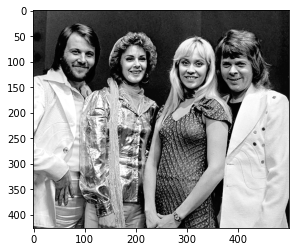

[[168  70  66  66]
 [ 56  55  75  75]
 [267  69  87  87]
 [354  78  74  74]] <class 'numpy.ndarray'>


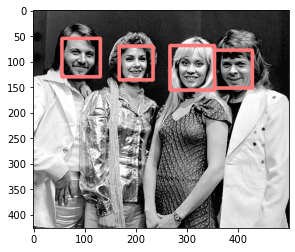

In [59]:
# Sample stock image from training article works fine 
a = tag_face('/Users/nealdesai/Documents/CSClasses/CS766-CV/project/HumanEmotionRecognition/abba.png', show=True, cropped=False)

body coordinates gft:  [  76.  760. 1484. 3396.]
Body coordinates tf:  [76, 760, 1484, 3396]
original image: 


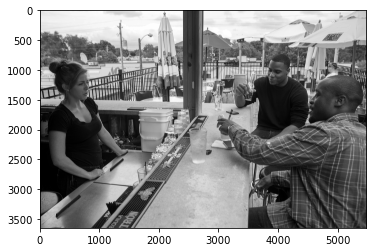

cropped image: 


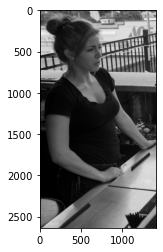

[[895 393  62  62]
 [279 469  88  88]] <class 'numpy.ndarray'>


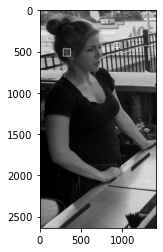

body coordinates gft:  [3229.  700. 4586. 2503.]
Body coordinates tf:  [3229, 700, 4586, 2503]
original image: 


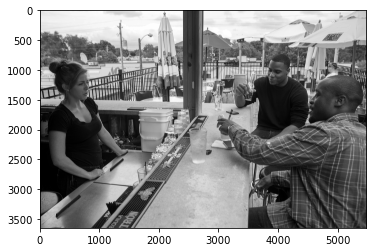

cropped image: 


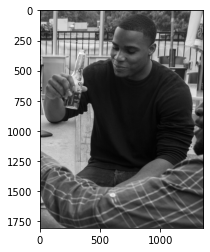

() <class 'tuple'>


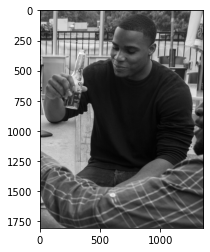

body coordinates gft:  [4051.  981. 5476. 3579.]
Body coordinates tf:  [4051, 981, 5476, 3579]
original image: 


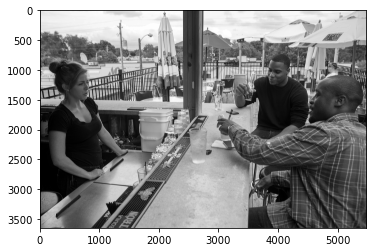

cropped image: 


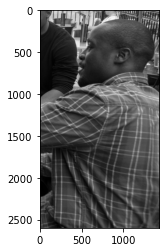

[[931  18  58  58]] <class 'numpy.ndarray'>


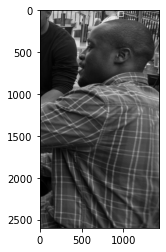

In [60]:
def runTest(imageNum):
    data = get_img_path(39)
    f = get_face_tags(data[0])


Body coordinates tf:  [0, 0, 0, 0]
original image: 


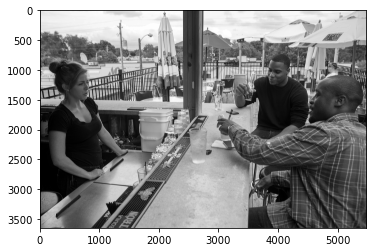

[[3636  680   66   66]
 [2709  686   83   83]
 [ 655  709   89   89]
 [ 446  737   87   87]
 [4311  719  115  115]
 [4982  998   60   60]
 [ 356 1227   88   88]
 [ 971 1153   60   60]] <class 'numpy.ndarray'>


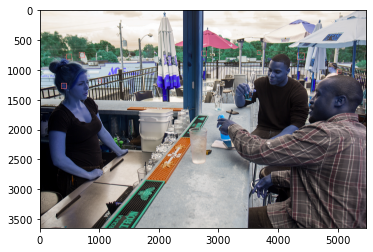

In [61]:
b = tag_face(data[1], show=True, cropped=False)


In [62]:
print(b)

[[3636  680   66   66]
 [2709  686   83   83]
 [ 655  709   89   89]
 [ 446  737   87   87]
 [4311  719  115  115]
 [4982  998   60   60]
 [ 356 1227   88   88]
 [ 971 1153   60   60]]
